In [129]:
!kaggle datasets download -d mohamedmaher5/vehicle-classification

Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification
License(s): CC0-1.0
vehicle-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [130]:
# unzip 명령어가 안 먹힘
# !unzip -qq vehicle-classification.zip -d ./

import zipfile
import os

currentDir = os.getcwd()

zipFilePath = os.path.join(currentDir, 'vehicle-classification.zip')
extractPath = currentDir

with zipfile.ZipFile(zipFilePath, 'r') as zip_ref:
    zip_ref.extractall(extractPath)

print(f'압축 해제 완료 : {zipFilePath} -> {extractPath}')

압축 해제 완료 : c:\Users\yjkim\pytorch_study\sesac\vehicle-classification.zip -> c:\Users\yjkim\pytorch_study\sesac


In [131]:
import os

os.getcwd()

'c:\\Users\\yjkim\\pytorch_study\\sesac'

In [132]:
import os

dataPath = os.path.join(os.getcwd(), 'Vehicles')
dataFolder = os.listdir(dataPath)
print(dataFolder)
print(len(dataFolder))

['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']
7


In [133]:
Vehicles_tvt = 'Vehicles_tvt'
v_train = os.path.join(Vehicles_tvt, 'train')
v_valid = os.path.join(Vehicles_tvt, 'valid')
v_test = os.path.join(Vehicles_tvt, 'test')

os.makedirs(v_train, exist_ok=True)
os.makedirs(v_valid, exist_ok=True)
os.makedirs(v_test, exist_ok=True)

for folder in dataFolder:
    train_temp = os.path.join(v_train, folder)
    os.makedirs(train_temp, exist_ok=True)
    valid_temp = os.path.join(v_valid, folder)
    os.makedirs(valid_temp, exist_ok=True)

In [134]:
for folder in dataFolder:
    class_len = os.listdir(os.path.join(dataPath, folder))
    temp = len(class_len)
    print(temp)

800
800
790
800
800
800
800


In [135]:
import random, shutil

random.seed(0)

train_ratio = 0.8
valid_ratio = 0.15

dataPath_train = os.path.join(os.getcwd(), 'Vehicles_tvt\\train')
dataPath_valid = os.path.join(os.getcwd(), 'Vehicles_tvt\\valid')
dataPath_test = os.path.join(os.getcwd(), 'Vehicles_tvt\\test')
# print(dataPath_train)
# print(dataPath_valid)
# print(dataPath_test)

if not os.listdir(dataPath_test):
    for folder in dataFolder:
        classFolder = os.path.join(dataPath, folder)
        fileList = os.listdir(classFolder)

        dataSize = len(fileList)
        
        trainCount = int(dataSize * train_ratio)
        validCount = int(dataSize * valid_ratio)
        testCount = dataSize - trainCount - validCount
        # print(dataSize)
        indices = list(range(dataSize))
        # print(indices)

        trainList = random.sample(indices, trainCount)
        remaining_indices = list(set(indices) - set(trainList))
        # print(remaining_indices)

        validList = random.sample(remaining_indices, validCount)

        testList = list(set(remaining_indices) - set(validList))

        trainData = [fileList[i] for i in trainList]
        validData = [fileList[i] for i in validList]
        testData = [fileList[i] for i in testList]

        for data in trainData:
            oldPath = os.path.join(classFolder, data)
            newPath = os.path.join(dataPath_train, folder)
            # print(oldPath, newPath)
            # break
            shutil.copy(oldPath, newPath)
        for data in validData:
            oldPath = os.path.join(classFolder, data)
            newPath = os.path.join(dataPath_valid, folder)
            # print(oldPath, newPath)
            # break
            shutil.copy(oldPath, newPath)
        for data in testData:
            oldPath = os.path.join(classFolder, data)
            newPath = dataPath_test
            # print(oldPath, newPath)
            # break
            shutil.copy(oldPath, newPath)
else:
    print('폴더가 비어 있지 않습니다.')

폴더가 비어 있지 않습니다.


In [136]:
for folder in dataFolder:
    print(folder, len(os.listdir(os.path.join(dataPath_train, folder))))
print('----------')
for folder in dataFolder:
    print(folder, len(os.listdir(os.path.join(dataPath_valid, folder))))
print('----------')
print(f'test data length per class : {int(len(os.listdir(dataPath_test))/len(dataFolder))}')

Auto Rickshaws 640
Bikes 640
Cars 632
Motorcycles 640
Planes 640
Ships 640
Trains 640
----------
Auto Rickshaws 120
Bikes 120
Cars 118
Motorcycles 120
Planes 120
Ships 120
Trains 120
----------
test data length per class : 40


In [137]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

data_dir = os.path.join(os.getcwd(), 'Vehicles_tvt')
print(data_dir)

c:\Users\yjkim\pytorch_study\sesac\Vehicles_tvt


In [138]:
# 아래 코드로 모든 이미지가 140, 140인지는 알 수 없음.
# 나중에 모든 이미지 크기를 matplotlib로 시각화하는 코드 짜보기?

import cv2

img_dir = os.path.join(dataPath_train, dataFolder[0])
img_test = os.listdir(img_dir)

img = cv2.imread(os.path.join(img_dir, img_test[0]))
img.shape

(140, 140, 3)

In [139]:
from torchvision import transforms

# 2는 나중에 실험해보기(연산량 늘 것 같음)
org_size1 = (224, 224)
org_size2 = (256, 256)

transform = transforms.Compose([
    transforms.Resize(org_size1),
    transforms.ToTensor()
])

In [140]:
# 아래 코드는 test 폴더 안에 클래스 폴더들이 없다고 에러가 뜸

# from torchvision.datasets import ImageFolder

# class ImageFolderWithFilenames(ImageFolder):
#     def __getitem__(self, index):
#         original_tuple = super(ImageFolderWithFilenames, self).__getitem__(index)

#         path, _ = self.samples[index]

#         return original_tuple + (path, )

In [141]:
from torch.utils.data import Dataset
from PIL import Image
import os

class TestDatasetWithClassNames(Dataset):
    def __init__(self, root, transform=None, seed=42):
        self.root = root
        self.transform = transform
        self.imgs = [img for img in os.listdir(root) if img.endswith('.jpg') or img.endswith('.png')]
        
        random.seed(seed)
        random.shuffle(self.imgs)

        self.classNames = [self.extract_class_name(img).replace('_', ' ') for img in self.imgs]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set(self.classNames)))}
        self.length = len(self.imgs)

    def extract_class_name(self, filename):
        return '_'.join(filename.split(' ')[:-1])
    
    def __getitem__(self, index):
        imgName = os.path.join(self.root, self.imgs[index])
        image = Image.open(imgName).convert('RGB')
        imgPath = os.path.join(self.root, imgName)

        if self.transform:
            image = self.transform(image)

        className = self.classNames[index]
        classIdx = self.class_to_idx[className]

        return image, classIdx, imgPath

    def __len__(self):
        return self.length

In [142]:
train_data = ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
valid_data = ImageFolder(root=os.path.join(data_dir, 'valid'), transform=transform)
test_data = TestDatasetWithClassNames(root=os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [143]:
# 클래스 목록 출력(잘 섞였는지 확인)
print(test_data.classNames)

# 클래스와 인덱스의 매핑 출력
print(test_data.class_to_idx)

['Ship', 'Auto Rickshaw', 'Train', 'Train', 'Plane', 'Car', 'Car', 'Auto Rickshaw', 'Auto Rickshaw', 'Ship', 'Ship', 'Motorcycle', 'Train', 'Plane', 'Car', 'Car', 'Car', 'Bike', 'Car', 'Motorcycle', 'Plane', 'Motorcycle', 'Ship', 'Bike', 'Car', 'Train', 'Ship', 'Ship', 'Motorcycle', 'Plane', 'Train', 'Plane', 'Train', 'Bike', 'Bike', 'Motorcycle', 'Plane', 'Car', 'Auto Rickshaw', 'Car', 'Plane', 'Ship', 'Motorcycle', 'Auto Rickshaw', 'Train', 'Car', 'Ship', 'Train', 'Bike', 'Auto Rickshaw', 'Motorcycle', 'Bike', 'Bike', 'Train', 'Bike', 'Motorcycle', 'Plane', 'Motorcycle', 'Bike', 'Train', 'Ship', 'Auto Rickshaw', 'Motorcycle', 'Ship', 'Train', 'Train', 'Ship', 'Car', 'Bike', 'Ship', 'Car', 'Car', 'Auto Rickshaw', 'Plane', 'Plane', 'Plane', 'Auto Rickshaw', 'Bike', 'Bike', 'Motorcycle', 'Ship', 'Plane', 'Train', 'Ship', 'Car', 'Auto Rickshaw', 'Bike', 'Car', 'Auto Rickshaw', 'Auto Rickshaw', 'Train', 'Bike', 'Plane', 'Motorcycle', 'Plane', 'Plane', 'Car', 'Motorcycle', 'Motorcycle', 'C

In [144]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [145]:
model = resnet50(pretrained=True).to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [146]:
%pip install pytorch-ignite

Note: you may need to restart the kernel to use updated packages.


In [147]:
modelPath = os.path.join(os.getcwd(), 'vehicle_model')

if not os.path.exists(modelPath):
    os.makedirs(modelPath)

In [148]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path=None):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

modelPath = os.path.join(modelPath, 'resnet50_best.pth')

early_stopping = EarlyStopping(patience=7, verbose=True, path = modelPath)

In [149]:
model = resnet50(pretrained=True).to(device)

num_features = model.fc.in_features

num_classes = 7

model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 256),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(256),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, num_classes)
).to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [150]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit(model, criterion, optimizer, epochs, train_loader, valid_loader, resume=False):

    if resume == False:
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()

        model.train()

        train_loss = 0
        train_acc = 0
        train_correct = 0

        for train_x, train_y in tqdm(train_loader):
            train_x, train_y = train_x.to(device), train_y.to(device)
            outputs = model(train_x)

            loss = criterion(outputs, train_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == train_y).sum().item()

        valid_loss = 0
        valid_acc = 0
        valid_correct = 0

        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device)
                outputs = model(valid_x)

                loss = criterion(outputs, valid_y)

                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                valid_correct += (predicted == valid_y).sum().item()

        train_acc = train_correct / len(train_loader.dataset)
        valid_acc = valid_correct / len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss : {train_loss/len(train_loader):.4f}, train_acc : {train_acc*100:.3f}% / valid loss : {valid_loss / len(valid_loader):.4f}, valid_acc : {valid_acc*100:.3f}%')

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(valid_acc)

        scheduler.step(valid_loss)

        now_lr = optimizer.param_groups[0]['lr']
        print(f'learning_rate {epoch+1} : {now_lr:.8f}')

        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print('Early stopping triggered.')
            break
        print('-' * 100)

    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()

    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

100%|██████████| 70/70 [01:55<00:00,  1.66s/it]


125.346sec : [Epoch 1/30] -> train loss : 0.3831, train_acc : 87.299% / valid loss : 0.2576, valid_acc : 91.756%
learning_rate 1 : 0.00100000
Validation loss decreased (inf --> 13.653236). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:53<00:00,  1.62s/it]


123.095sec : [Epoch 2/30] -> train loss : 0.1838, train_acc : 93.918% / valid loss : 0.4331, valid_acc : 86.858%
learning_rate 2 : 0.00100000
EarlyStopping counter: 1 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:52<00:00,  1.61s/it]


121.959sec : [Epoch 3/30] -> train loss : 0.1838, train_acc : 94.052% / valid loss : 1.2819, valid_acc : 68.937%
learning_rate 3 : 0.00100000
EarlyStopping counter: 2 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:57<00:00,  1.68s/it]


126.799sec : [Epoch 4/30] -> train loss : 0.1307, train_acc : 95.886% / valid loss : 0.5386, valid_acc : 84.827%
learning_rate 4 : 0.00100000
EarlyStopping counter: 3 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:55<00:00,  1.65s/it]


124.785sec : [Epoch 5/30] -> train loss : 0.1014, train_acc : 96.869% / valid loss : 0.2457, valid_acc : 92.115%
learning_rate 5 : 0.00100000
Validation loss decreased (13.653236 --> 13.021224). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:56<00:00,  1.66s/it]


125.744sec : [Epoch 6/30] -> train loss : 0.0553, train_acc : 98.390% / valid loss : 0.8480, valid_acc : 77.539%
learning_rate 6 : 0.00100000
EarlyStopping counter: 1 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:53<00:00,  1.62s/it]


122.936sec : [Epoch 7/30] -> train loss : 0.0834, train_acc : 97.496% / valid loss : 0.4168, valid_acc : 86.022%
learning_rate 7 : 0.00100000
EarlyStopping counter: 2 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:46<00:00,  1.52s/it]


115.278sec : [Epoch 8/30] -> train loss : 0.0982, train_acc : 96.780% / valid loss : 0.3771, valid_acc : 89.725%
learning_rate 8 : 0.00100000
EarlyStopping counter: 3 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:46<00:00,  1.53s/it]


116.310sec : [Epoch 9/30] -> train loss : 0.0700, train_acc : 97.719% / valid loss : 0.3337, valid_acc : 91.637%
learning_rate 9 : 0.00050000
EarlyStopping counter: 4 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:48<00:00,  1.55s/it]


117.319sec : [Epoch 10/30] -> train loss : 0.0252, train_acc : 99.374% / valid loss : 0.0787, valid_acc : 97.491%
learning_rate 10 : 0.00050000
Validation loss decreased (13.021224 --> 4.171070). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:46<00:00,  1.52s/it]


116.164sec : [Epoch 11/30] -> train loss : 0.0070, train_acc : 99.866% / valid loss : 0.0769, valid_acc : 97.849%
learning_rate 11 : 0.00050000
Validation loss decreased (4.171070 --> 4.073200). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:44<00:00,  1.49s/it]


113.623sec : [Epoch 12/30] -> train loss : 0.0065, train_acc : 99.866% / valid loss : 0.0745, valid_acc : 98.208%
learning_rate 12 : 0.00050000
Validation loss decreased (4.073200 --> 3.945856). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:45<00:00,  1.51s/it]


115.074sec : [Epoch 13/30] -> train loss : 0.0040, train_acc : 99.911% / valid loss : 0.0766, valid_acc : 97.611%
learning_rate 13 : 0.00050000
EarlyStopping counter: 1 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:46<00:00,  1.53s/it]


116.086sec : [Epoch 14/30] -> train loss : 0.0037, train_acc : 99.933% / valid loss : 0.0814, valid_acc : 97.730%
learning_rate 14 : 0.00050000
EarlyStopping counter: 2 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:47<00:00,  1.53s/it]


117.152sec : [Epoch 15/30] -> train loss : 0.0018, train_acc : 99.978% / valid loss : 0.0692, valid_acc : 97.611%
learning_rate 15 : 0.00050000
Validation loss decreased (3.945856 --> 3.665197). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:45<00:00,  1.50s/it]


114.583sec : [Epoch 16/30] -> train loss : 0.0016, train_acc : 100.000% / valid loss : 0.0617, valid_acc : 97.730%
learning_rate 16 : 0.00050000
Validation loss decreased (3.665197 --> 3.268537). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:45<00:00,  1.50s/it]


115.007sec : [Epoch 17/30] -> train loss : 0.0015, train_acc : 100.000% / valid loss : 0.0700, valid_acc : 97.730%
learning_rate 17 : 0.00050000
EarlyStopping counter: 1 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:47<00:00,  1.54s/it]


116.887sec : [Epoch 18/30] -> train loss : 0.0033, train_acc : 99.911% / valid loss : 0.0716, valid_acc : 97.849%
learning_rate 18 : 0.00050000
EarlyStopping counter: 2 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:44<00:00,  1.50s/it]


113.920sec : [Epoch 19/30] -> train loss : 0.0012, train_acc : 100.000% / valid loss : 0.0602, valid_acc : 98.088%
learning_rate 19 : 0.00050000
Validation loss decreased (3.268537 --> 3.189969). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:39<00:00,  1.43s/it]


109.145sec : [Epoch 20/30] -> train loss : 0.0008, train_acc : 100.000% / valid loss : 0.0593, valid_acc : 98.088%
learning_rate 20 : 0.00050000
Validation loss decreased (3.189969 --> 3.143404). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


110.900sec : [Epoch 21/30] -> train loss : 0.0007, train_acc : 100.000% / valid loss : 0.0601, valid_acc : 98.327%
learning_rate 21 : 0.00050000
EarlyStopping counter: 1 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:52<00:00,  1.60s/it]


121.527sec : [Epoch 22/30] -> train loss : 0.0007, train_acc : 100.000% / valid loss : 0.0585, valid_acc : 97.969%
learning_rate 22 : 0.00050000
Validation loss decreased (3.143404 --> 3.102692). Saving model ...
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


111.120sec : [Epoch 23/30] -> train loss : 0.0007, train_acc : 100.000% / valid loss : 0.0661, valid_acc : 98.088%
learning_rate 23 : 0.00050000
EarlyStopping counter: 1 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


111.000sec : [Epoch 24/30] -> train loss : 0.0010, train_acc : 99.978% / valid loss : 0.0758, valid_acc : 97.611%
learning_rate 24 : 0.00050000
EarlyStopping counter: 2 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:45<00:00,  1.50s/it]


114.911sec : [Epoch 25/30] -> train loss : 0.0008, train_acc : 100.000% / valid loss : 0.0740, valid_acc : 98.088%
learning_rate 25 : 0.00050000
EarlyStopping counter: 3 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


111.963sec : [Epoch 26/30] -> train loss : 0.0006, train_acc : 100.000% / valid loss : 0.0722, valid_acc : 97.849%
learning_rate 26 : 0.00025000
EarlyStopping counter: 4 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:38<00:00,  1.41s/it]


108.209sec : [Epoch 27/30] -> train loss : 0.0004, train_acc : 100.000% / valid loss : 0.0692, valid_acc : 97.969%
learning_rate 27 : 0.00025000
EarlyStopping counter: 5 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:39<00:00,  1.43s/it]


109.315sec : [Epoch 28/30] -> train loss : 0.0004, train_acc : 100.000% / valid loss : 0.0771, valid_acc : 97.969%
learning_rate 28 : 0.00025000
EarlyStopping counter: 6 out of 7
----------------------------------------------------------------------------------------------------


100%|██████████| 70/70 [01:46<00:00,  1.51s/it]


115.720sec : [Epoch 29/30] -> train loss : 0.0004, train_acc : 100.000% / valid loss : 0.0617, valid_acc : 98.088%
learning_rate 29 : 0.00025000
EarlyStopping counter: 7 out of 7
Early stopping triggered.


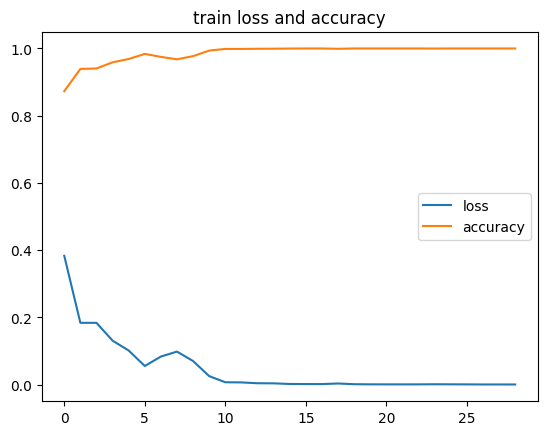

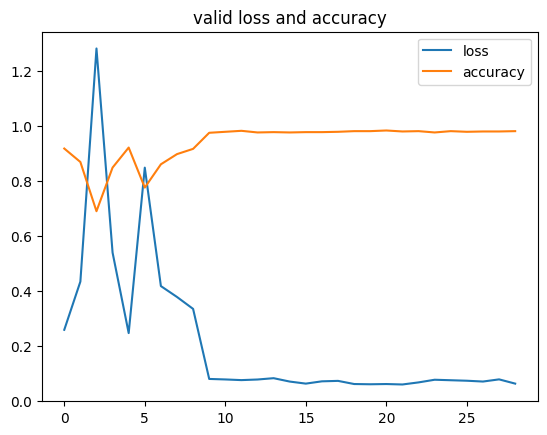

In [151]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr = 0.001
epochs = 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

fit(model, criterion, optimizer, epochs, train_loader, valid_loader, resume=False)

In [152]:
import matplotlib.pyplot as plt
from PIL import Image

def evaluate_and_visualize(model, test_loader, criterion):
    test_loss = 0
    test_correct = 0
    test_total = 0

    incorrect_labels = []
    incorrect_preds = []
    incorrect_filenames = []

    model.eval()
    with torch.no_grad():
        for test_x, test_y, filenames in tqdm(test_loader):
            test_x, test_y = test_x.to(device), test_y.to(device)
            outputs = model(test_x)

            loss = criterion(outputs, test_y)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            test_correct += (predicted == test_y).sum().item()
            test_total += test_y.size(0)

            if predicted != test_y:
                incorrect_labels.append(test_y.cpu().numpy())
                incorrect_preds.append(predicted.cpu().numpy())
                incorrect_filenames.append(filenames[0])

    test_accuracy = test_correct / test_total
    print(f'test_correct : {test_correct}, test_total : {test_total}')
    print(f'Test Loss : {test_loss / len(test_loader):.4f}, Test Accuracy : {test_accuracy * 100:.2f}%')

    print(f'틀린 개수: {len(incorrect_filenames)}')
    
    fig = plt.figure(figsize=(24,24))
    for i in range(min(16, len(incorrect_filenames))):
        ax = fig.add_subplot(4, 4, i + 1)
        image = Image.open(incorrect_filenames[i])
        ax.imshow(image)
        
        if incorrect_labels[i] == 0:
            true_label = 'Auto Rickshaw'
        elif incorrect_labels[i] == 1:
            true_label = 'Bike'
        elif incorrect_labels[i] == 2:
            true_label = 'Car'
        elif incorrect_labels[i] == 3:
            true_label = 'Motorcycle'
        elif incorrect_labels[i] == 4:
            true_label = 'Plane'
        elif incorrect_labels[i] == 5:
            true_label = 'Ship'
        elif incorrect_labels[i] == 6:
            true_label = 'Train'

        if incorrect_preds[i] == 0:
            pred_label = 'Auto Rickshaw'
        elif incorrect_preds[i] == 1:
            pred_label = 'Bike'
        elif incorrect_preds[i] == 2:
            pred_label = 'Car'
        elif incorrect_preds[i] == 3:
            pred_label = 'Motorcycle'
        elif incorrect_preds[i] == 4:
            pred_label = 'Plane'
        elif incorrect_preds[i] == 5:
            pred_label = 'Ship'
        elif incorrect_preds[i] == 6:
            pred_label = 'Train'
        # basename 파일 경로에서 파일 이름만 추출하는 함수
        filename = os.path.basename(incorrect_filenames[i])

        ax.set_title(f'Pred : {pred_label}, Label : {true_label}, {filename}', fontsize=14)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [153]:
# {'Auto Rickshaw': 0, 'Bike': 1, 'Car': 2, 'Motorcycle': 3, 'Plane': 4, 'Ship': 5, 'Train': 6}

100%|██████████| 275/275 [00:04<00:00, 60.66it/s]


test_correct : 270, test_total : 275
Test Loss : 0.0654, Test Accuracy : 98.18%
틀린 개수: 5


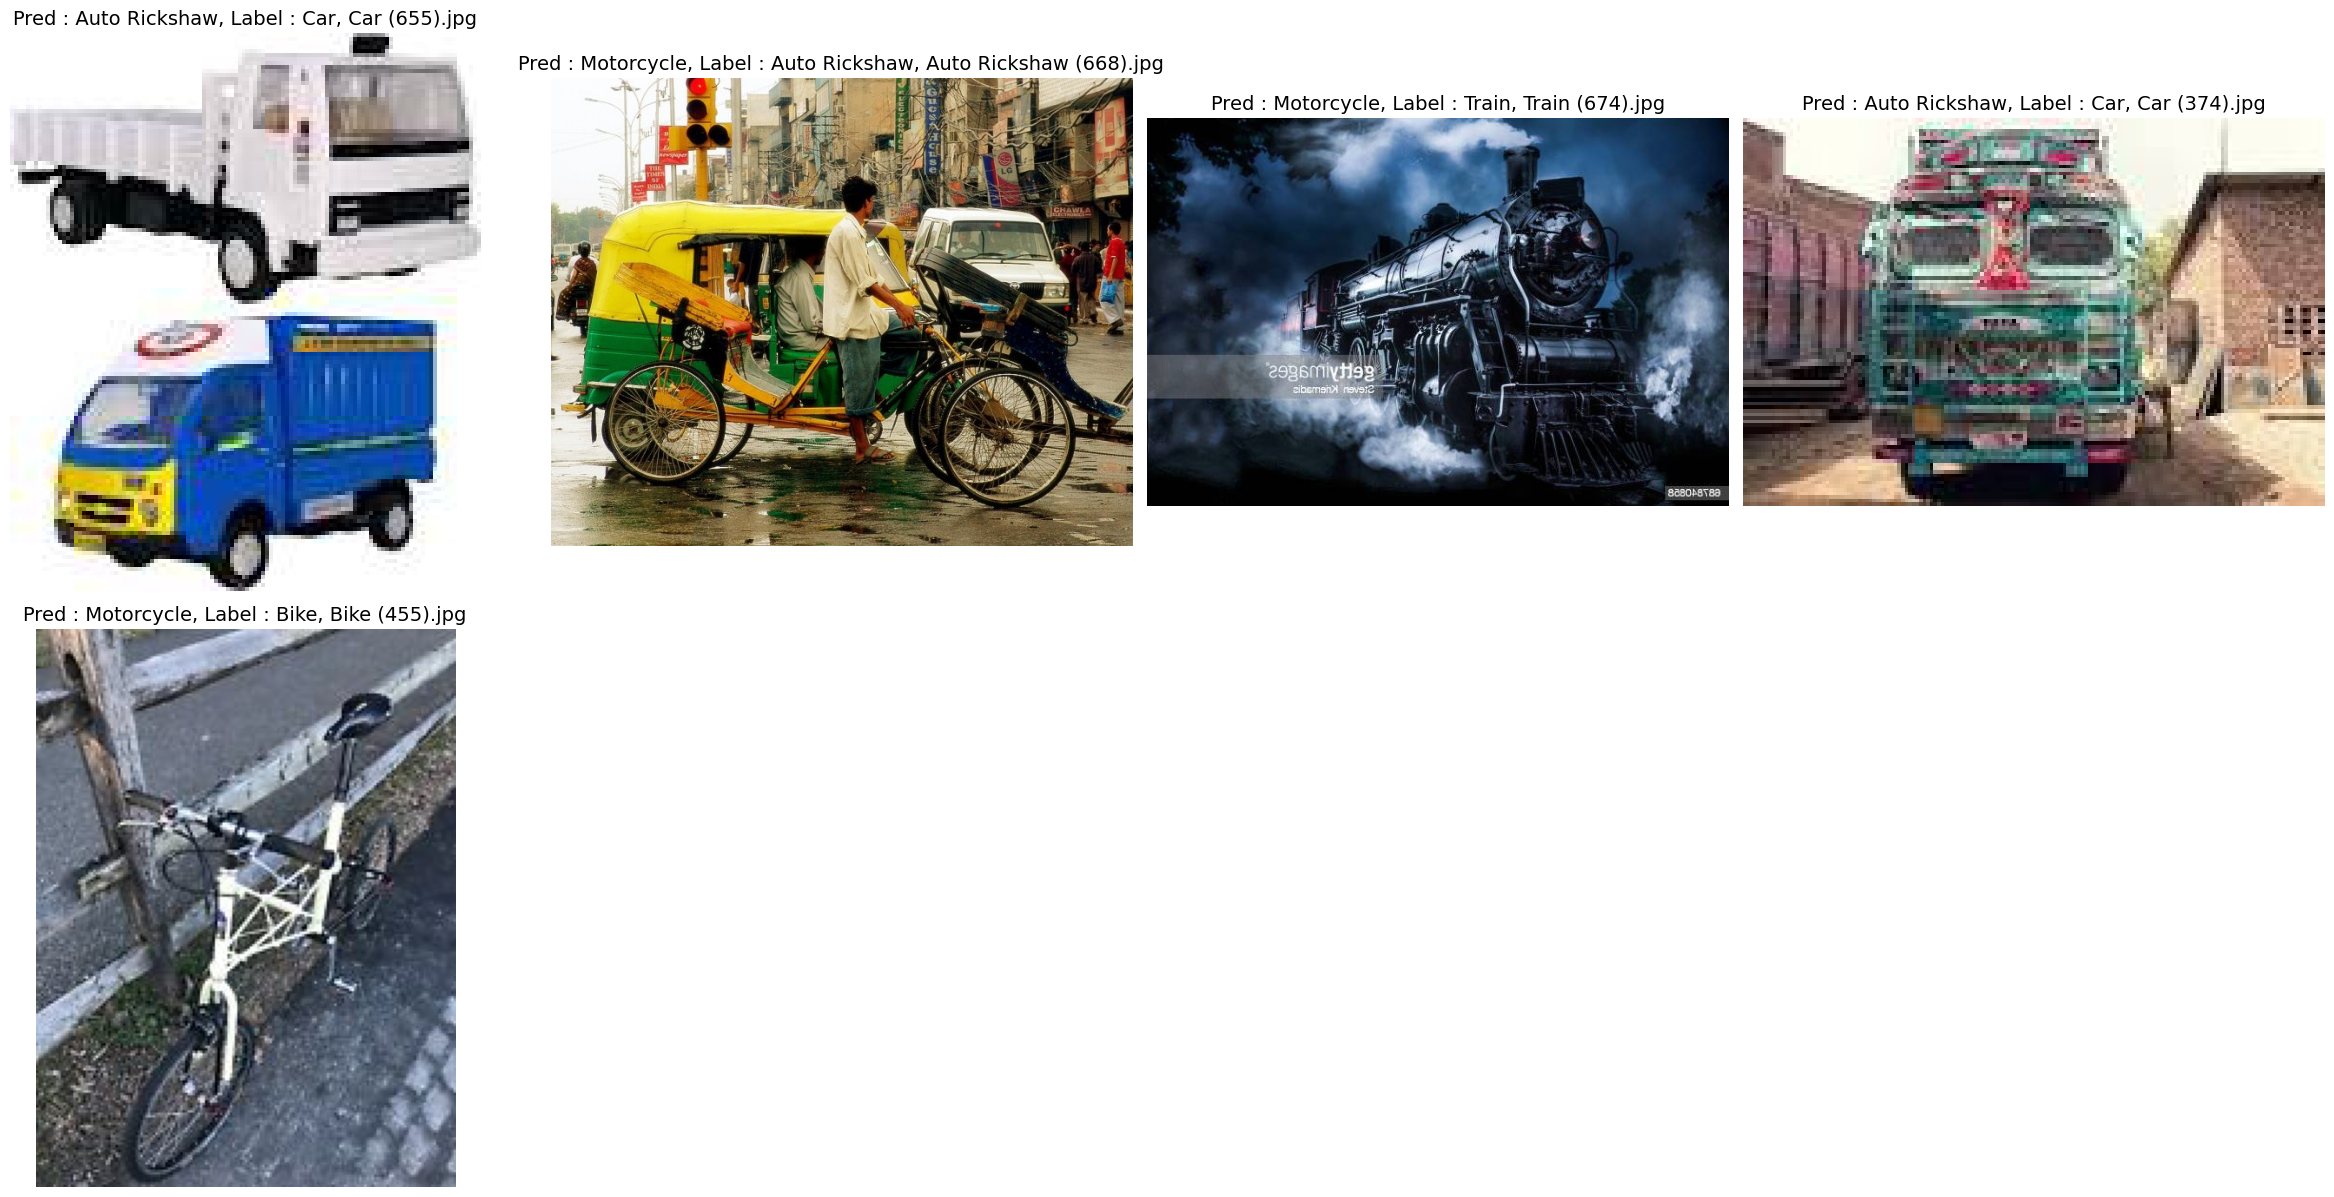

In [154]:
# ealrystopping의 patience=8로 줬을 때 test data 틀린 개수 7, epoch 30
# ealrystopping의 patience=4로 줬을 때 test data 틀린 개수 32, epoch 30
# ealrystopping의 patience=7로 줬을 때 test data 틀린 개수 5, epoch 30(25 정도로만 해도 될 것 같음)
evaluate_and_visualize(model, test_loader, criterion)